1. Download data for a week from https://data.stadt-zuerich.ch/dataset/vbz-fahrzeiten-ogd as csv. The files `Haltestelle.csv` and `Haltepunkt.csv` are needed too.
2. Since there are about 1.3 million rows in one file, we take a smaller subset from it to explore the data. Use `head -n 10000 fahrzeitensollist2017070220170708.csv > small.csv` (adjust the filename) to create the subset in `small.csv`.

In [1]:
%matplotlib inline
import numpy

from datetime import datetime, timedelta

import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd

# Not necessary, but I like the ggplot style better
plt.style.use('ggplot') 

# Read csv to dataframe
df = pd.read_csv('small.csv')
df_hpunkt = pd.read_csv('haltepunkt.csv')
df_hstelle = pd.read_csv('haltestelle.csv')

First let's create a simple histogram of how late or early the public transport was during the given time period. For that we will calculate the time differences between target and actual time. 

Then let's compare to a normal distribution for the mean and standard deviation of the time differences.

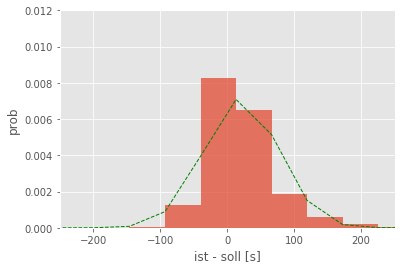

In [2]:
diffs = []
for index, row in df.iterrows():
    # Here the delay is calculated
    diff = row['ist_an_von'] - row['soll_an_von']
    diffs.append(diff)

# Calculate mean and std
mu = numpy.mean(diffs)
sigma = numpy.std(diffs)

n, bins, patches = plt.hist(diffs, bins=50, alpha=0.75, normed=1)

# Add normal distribution ("best fit")
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'g--', linewidth=1)

plt.xlabel('ist - soll [s]')
plt.ylabel('prob')
plt.grid(True)

# Adjust axis because of outliers
plt.axis([-250, 250, 0, 0.012]) # if there are too many outliers removed, you have to increase number of "bins" above to make a nice histogram

plt.show()

We can see that public transportation is often on time. It's a bit more often late than early.

Now let's create a timeline to see, if the delays differ depending on time. Also let's add the number of stops recorded to the plot.

The times will be rounded to the hour.

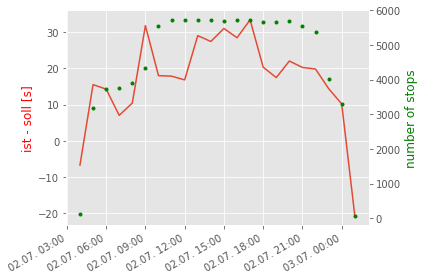

In [3]:
def makeDatetime(date, seconds):
    """Returns datetime object rounded to the hour.
    
    date: date in format dd.mm.yy
    seconds: seconds of the day (int, can be negative)
    """
    hour = int(seconds / 3600) # same as numpy.floor()
    minute = (seconds - hour * 3600) / 60

    dt_obj = datetime.strptime(date, '%d.%m.%y')
    if hour == 24:
        dt_obj += timedelta(days=1)
        hour = 0
    dt_obj = dt_obj.replace(hour=hour)

    return dt_obj

# Save differences in here as dt_obj -> [diffs]
tod_diff = {}
tod_count= {}
for index, row in df.iterrows():
    dt_obj = makeDatetime(row['datum_von'], row['soll_an_von']) # time from "soll"
    diff = row['ist_an_von'] - row['soll_an_von']

    if dt_obj not in tod_diff: 
        tod_diff[dt_obj] = []
        tod_count[dt_obj] = 0
        
    tod_diff[dt_obj].append(diff)
    tod_count[dt_obj] += 1
    
# Calculate average of every hour
# Sort by time
tod_times = [] # x
tod_avgs = [] # y
tod_counts = [] # y2
for dt_obj in sorted(tod_diff):
    dt_diffs = tod_diff[dt_obj]

    tod_times.append(dt_obj)
    tod_avgs.append(numpy.mean(dt_diffs))
    tod_counts.append(tod_count[dt_obj])

# Plot
fig, ax = plt.subplots(1)
fig.autofmt_xdate()

# y
ax.plot(tod_times, tod_avgs)
ax.set_ylabel('ist - soll [s]', color='r')
xfmt = mdates.DateFormatter('%d.%m. %H:%M')
ax.xaxis.set_major_formatter(xfmt)

# y2
ax2 = ax.twinx()
ax2.plot(tod_times, tod_counts, 'g.')
ax2.set_ylabel('number of stops', color='g')
ax2.grid(False)

fig.tight_layout()
plt.show()

There are peaks of being late around 8 a.m., 13 p.m., 15 p.m. and 17 p.m. Maybe because of traffic volume and/or passenger volume.
It's not clear if the number of stops correlates with it.

It would be interesting to know which stops are affected the most by public transportation being late (being late only!). There are multiple stops ("Haltepunkt") per station ("Haltestelle"). We are still interested into the stop, since we want to know which line was affected the most by delays.

In [4]:
halt_punkt_diffs = {}
halt_punkt_counter = {}
for index, row in df.iterrows():
    diff = row['ist_an_von'] - row['soll_an_von']
    if (diff < 0): continue # being early, we only care for being late
    
    if row['halt_punkt_id_von'] not in halt_punkt_diffs: 
        halt_punkt_diffs[row['halt_punkt_id_von']] = []
        halt_punkt_counter[row['halt_punkt_id_von']] = 0
        
    halt_punkt_diffs[row['halt_punkt_id_von']].append(diff)
    halt_punkt_counter[row['halt_punkt_id_von']] += 1
    
# Compute averages for every stop ("halt_punkt")
halt_punkt_avgs = {}
lat_long = {} # we will use this below
for key, diffs in halt_punkt_diffs.items():
    halt_punkt_avgs[key] = numpy.mean(diffs)
    
    # we will use this below, this doesn't scale well
    lat = float(df_hpunkt[df_hpunkt['halt_punkt_id'] == key]['GPS_Latitude'].item().replace(',', '.'))
    long = float(df_hpunkt[df_hpunkt['halt_punkt_id'] == key]['GPS_Longitude'].item().replace(',', '.'))
    lat_long[(lat, long)] = numpy.mean(diffs)

halt_punkt_avgs_sorted = sorted(halt_punkt_avgs.items(), key=lambda x:x[1])
print("**Smallest delay**")
for halt_punkt_id, avg_diff in halt_punkt_avgs_sorted[:10]:
    halt_id = df_hpunkt[df_hpunkt['halt_punkt_id'] == halt_punkt_id]['halt_id'].item()
    # We need this to get the long name of the train station for better legibility
    halt_lang = df_hstelle[df_hstelle['halt_id'] == halt_id]['halt_lang'].item()
    print("%s \t %.2f" % (halt_lang, avg_diff))

print("\n**Biggest delay**")
for halt_punkt_id, avg_diff in halt_punkt_avgs_sorted[-10:]:
    halt_id = df_hpunkt[df_hpunkt['halt_punkt_id'] == halt_punkt_id]['halt_id'].item()
    halt_lang = df_hstelle[df_hstelle['halt_id'] == halt_id]['halt_lang'].item()
    print("%s \t %.2f" % (halt_lang, avg_diff))

**Smallest delay**
Zürich, Friedhof Sihlfeld 	 0.00
Zürich, Frymannstrasse 	 6.00
Zürich, Escher-Wyss-Platz 	 8.00
Zürich, Schauenberg 	 8.53
Zürich, Butzenstrasse 	 10.00
Zürich, Bahnhof Tiefenbrunnen 	 12.43
Zürich, Friedhof Sihlfeld 	 13.00
Zürich, Bertastrasse 	 13.67
Zürich, Farbhof 	 13.78
Zürich, Messe/Hallenstadion 	 13.92

**Biggest delay**
Zürich, Farbhof 	 100.89
Zürich, Bäckeranlage 	 101.16
Zürich, Unteraffoltern 	 103.02
Zürich, Fronwald 	 103.14
Schlieren, Zentrum/Bahnhof 	 105.16
Zürich, Sackzelg 	 107.94
Zürich, Schulhaus Altweg 	 109.11
Zürich, In der Ey 	 110.52
Zürich, Schwandenholz 	 118.55
Zürich, Bahnhof Oerlikon 	 132.08


It is clear that if one line is affected by some delay, all of it's stops have a higher delay in average.

Maybe an areal plot will show if there are "hot spots" for delays. This part uses `gmaps` (https://github.com/pbugnion/gmaps) as an extension of jupyter notebooks and it needs an Google API key.

In [5]:
import gmaps

# use your own api here
from api import api
gmaps.configure(api_key=api)

fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(lat_long.keys(), weights=lat_long.values()))
# This doesn't show on github since it uses a javascript extension
#fig 

# So I'll just show a picture of it
from IPython.display import Image
Image(url="map.png")

### Scaling

If we want to work with more data, we need to load it from a database since loading CSV files into memory is slow and not memory-efficient.